In [882]:
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [883]:
HOUSING_PATH_FULL='C:/Users/samys/PycharmProjects/HousingPrices/data/Melbourne_housing_FULL.csv'

def load_housing_data(housing_path=HOUSING_PATH_FULL):
    return pd.read_csv(housing_path)

In [884]:
loaded_data = load_housing_data()
loaded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         34857 non-null  object 
 1   Address        34857 non-null  object 
 2   Rooms          34857 non-null  int64  
 3   Type           34857 non-null  object 
 4   Price          27247 non-null  float64
 5   Method         34857 non-null  object 
 6   SellerG        34857 non-null  object 
 7   Date           34857 non-null  object 
 8   Distance       34856 non-null  float64
 9   Postcode       34856 non-null  float64
 10  Bedroom2       26640 non-null  float64
 11  Bathroom       26631 non-null  float64
 12  Car            26129 non-null  float64
 13  Landsize       23047 non-null  float64
 14  BuildingArea   13742 non-null  float64
 15  YearBuilt      15551 non-null  float64
 16  CouncilArea    34854 non-null  object 
 17  Lattitude      26881 non-null  float64
 18  Longti

In [885]:
train_val_set = loaded_data.dropna(subset=['Price'])
final_test = loaded_data[loaded_data['Price'].isna()]
print(f"Number of rows in train_val_set: {len(train_val_set)}")
print(f"Number of rows in final_test: {len(final_test)}")

new_column_names = {'Lattitude': 'Latitude', 'Longtitude': 'Longitude'}
melb_data = train_val_set.rename(columns=new_column_names)

PRICE_MEAN = melb_data['Price'].mean()
print(f'PRICE_MEAN = {PRICE_MEAN}'  )
PRICE_MEDIAN = melb_data['Price'].median()
print(f'PRICE_MEDIAN = {PRICE_MEDIAN}')

Number of rows in train_val_set: 27247
Number of rows in final_test: 7610
PRICE_MEAN = 1050173.344955408
PRICE_MEDIAN = 870000.0


In [886]:
TRAINING_L_U = []
def remove_outliers_iqr_all(df, columns, factor=1.5, IS_TRAIN=False):
    df_clean = df.copy()
    outlier_mask = pd.Series(False, index=df_clean.index)

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        if IS_TRAIN:
            TRAINING_L_U.append([col, lower, upper])
        outlier_mask |= (df_clean[col] < lower) | (df_clean[col] > upper)

    num_outliers = outlier_mask.sum()
    df_clean = df_clean[~outlier_mask]

    print(f"Total number of outliers: {num_outliers}")
    print(f"Number of rows after removal: {len(df_clean)}")
    return df_clean


In [887]:
cols = ["Distance", "Bedroom2", "Bathroom", "Car", "Landsize", "Propertycount"]
melb_data = remove_outliers_iqr_all(melb_data, cols, IS_TRAIN=True)
melb_data = remove_outliers_iqr_all(melb_data, ['Price'], factor=1.5)

Total number of outliers: 3510
Number of rows after removal: 23737
Total number of outliers: 1026
Number of rows after removal: 22711


In [888]:
train_set, test_set = train_test_split(melb_data, test_size=0.2, random_state=42)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18168 entries, 34573 to 23910
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         18168 non-null  object 
 1   Address        18168 non-null  object 
 2   Rooms          18168 non-null  int64  
 3   Type           18168 non-null  object 
 4   Price          18168 non-null  float64
 5   Method         18168 non-null  object 
 6   SellerG        18168 non-null  object 
 7   Date           18168 non-null  object 
 8   Distance       18167 non-null  float64
 9   Postcode       18167 non-null  float64
 10  Bedroom2       13536 non-null  float64
 11  Bathroom       13533 non-null  float64
 12  Car            13268 non-null  float64
 13  Landsize       11745 non-null  float64
 14  BuildingArea   6904 non-null   float64
 15  YearBuilt      7898 non-null   float64
 16  CouncilArea    18166 non-null  object 
 17  Latitude       13671 non-null  float64
 18  Longitu

In [889]:
# train_set = remove_outliers_iqr_all(train_set, cols)


train_set['Price'] = np.log1p(train_set['Price'])
test_set['Price'] = np.log1p(test_set['Price'])

In [890]:
housing = train_set.copy()
numerical_features = train_set.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train_set.select_dtypes(include=['object']).columns.tolist()

print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)

Numerical features: ['Rooms', 'Price', 'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 'Latitude', 'Longitude', 'Propertycount']
Categorical features: ['Suburb', 'Address', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


array([[<Axes: title={'center': 'Rooms'}>,
        <Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Distance'}>,
        <Axes: title={'center': 'Postcode'}>],
       [<Axes: title={'center': 'Bedroom2'}>,
        <Axes: title={'center': 'Bathroom'}>,
        <Axes: title={'center': 'Car'}>,
        <Axes: title={'center': 'Landsize'}>],
       [<Axes: title={'center': 'BuildingArea'}>,
        <Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'Latitude'}>,
        <Axes: title={'center': 'Longitude'}>],
       [<Axes: title={'center': 'Propertycount'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

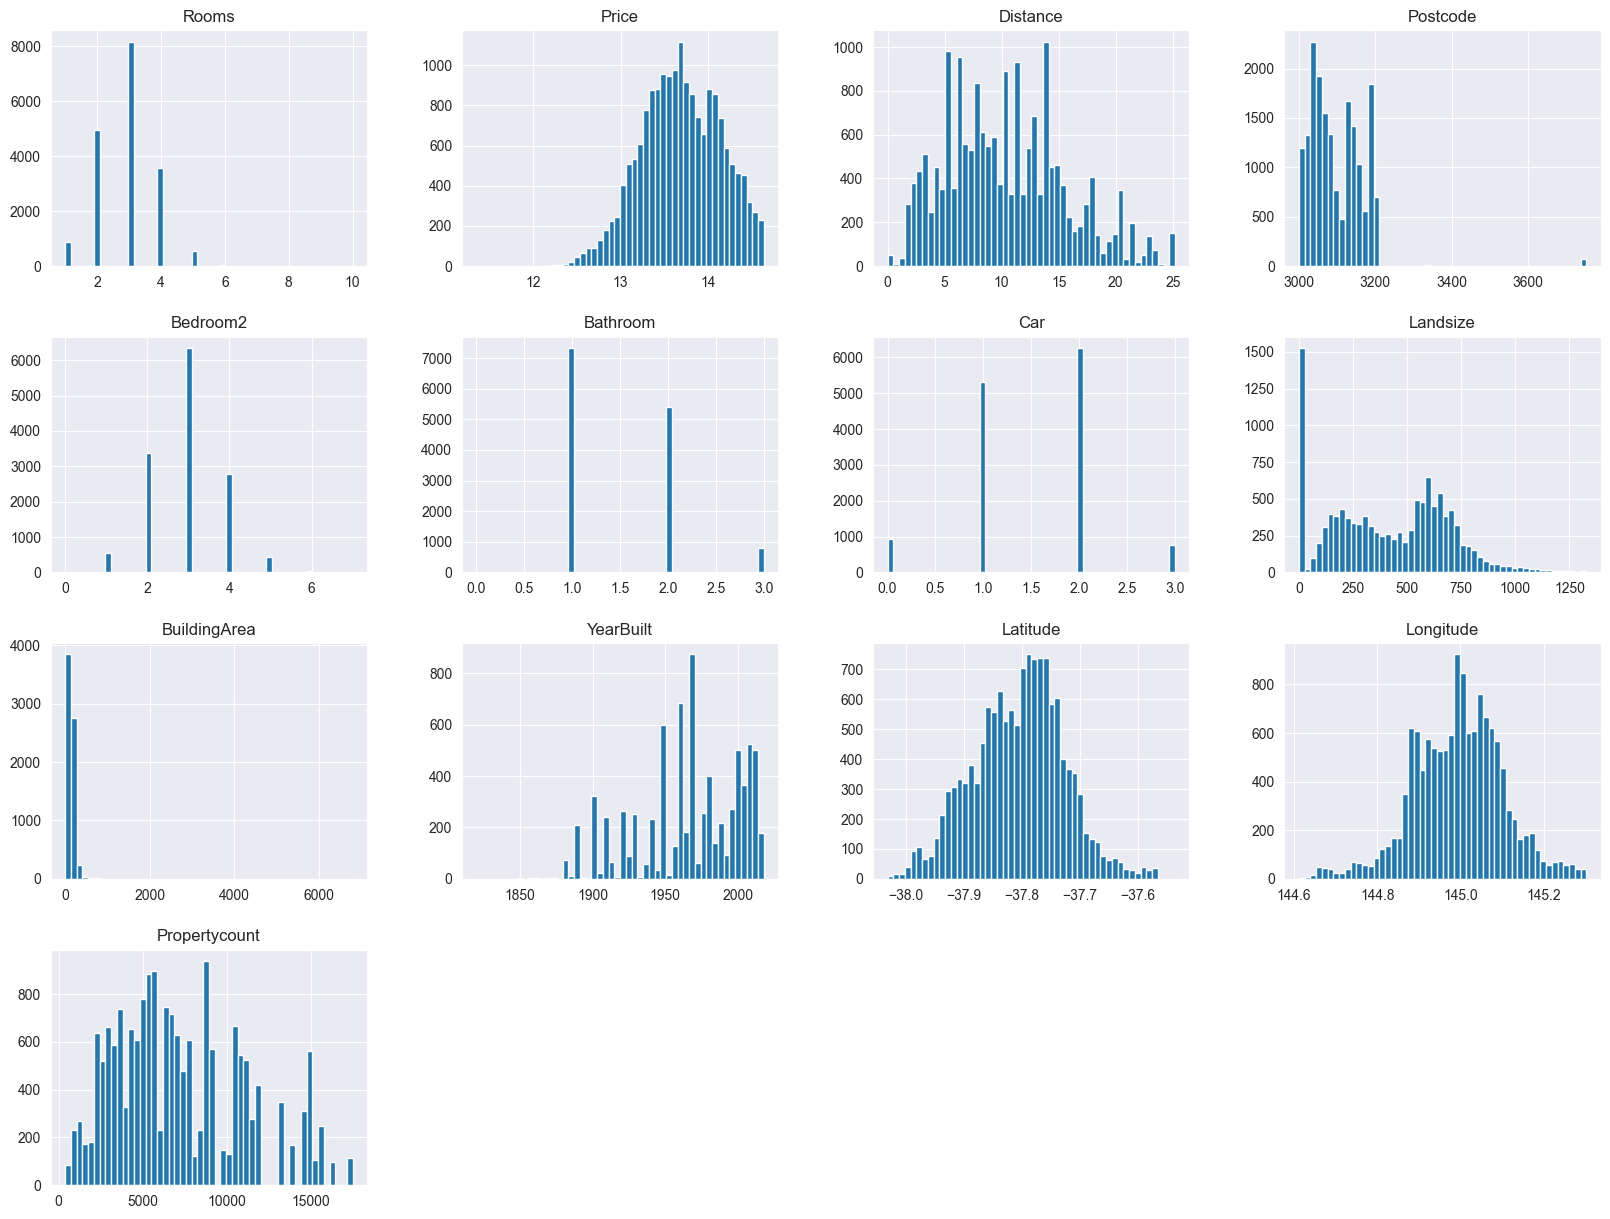

In [891]:
housing_num = housing[numerical_features]
housing.hist(bins=50, figsize=(20, 15))

In [892]:
corr_matrix = housing_num.corr()
corr_matrix["Price"].sort_values(ascending=False)

Price            1.000000
Rooms            0.522098
Bedroom2         0.469870
Bathroom         0.336715
Landsize         0.316596
Longitude        0.273448
BuildingArea     0.254918
Car              0.219054
Postcode         0.188862
Propertycount   -0.046118
Distance        -0.112466
Latitude        -0.254713
YearBuilt       -0.373344
Name: Price, dtype: float64

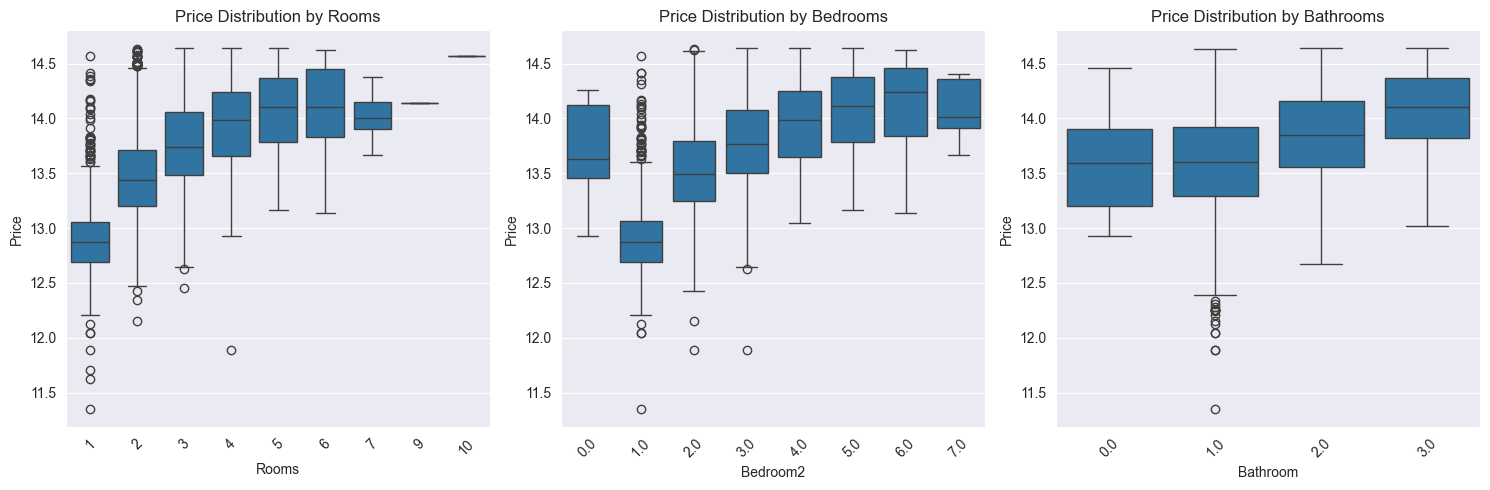

In [893]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Price vs Rooms
sns.boxplot(data=housing, x='Rooms', y='Price', ax=axes[0])
axes[0].set_title('Price Distribution by Rooms')
axes[0].tick_params(axis='x', rotation=45)

# Price vs Bedrooms
sns.boxplot(data=housing, x='Bedroom2', y='Price', ax=axes[1])
axes[1].set_title('Price Distribution by Bedrooms')
axes[1].tick_params(axis='x', rotation=45)

# Price vs Bathrooms
sns.boxplot(data=housing, x='Bathroom', y='Price', ax=axes[2])
axes[2].set_title('Price Distribution by Bathrooms')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()

In [894]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18168 entries, 34573 to 23910
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         18168 non-null  object 
 1   Address        18168 non-null  object 
 2   Rooms          18168 non-null  int64  
 3   Type           18168 non-null  object 
 4   Price          18168 non-null  float64
 5   Method         18168 non-null  object 
 6   SellerG        18168 non-null  object 
 7   Date           18168 non-null  object 
 8   Distance       18167 non-null  float64
 9   Postcode       18167 non-null  float64
 10  Bedroom2       13536 non-null  float64
 11  Bathroom       13533 non-null  float64
 12  Car            13268 non-null  float64
 13  Landsize       11745 non-null  float64
 14  BuildingArea   6904 non-null   float64
 15  YearBuilt      7898 non-null   float64
 16  CouncilArea    18166 non-null  object 
 17  Latitude       13671 non-null  float64
 18  Longitu

In [895]:

drop_cols = ["BuildingArea", "YearBuilt", "Postcode", "Latitude", "Longitude", "Address"]
housing_clean = housing.drop(columns=drop_cols)

important_dropna_cols = ["Distance", "CouncilArea", "Regionname","Bedroom2", "Bathroom", "Car"]
housing_clean = housing_clean.dropna(subset=important_dropna_cols)

median_impute_cols = ["Landsize"]
mean_impute_cols = ["Propertycount"]

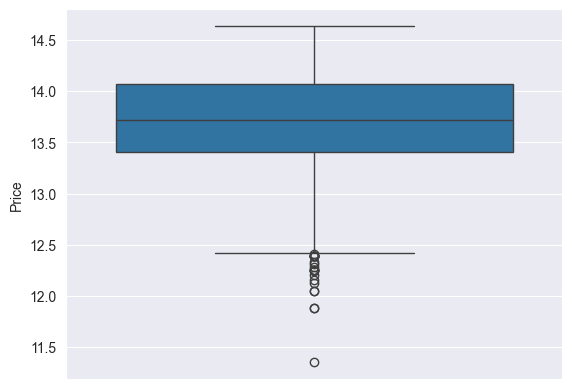

In [896]:

sns.boxplot(data=housing_clean, y='Price')
plt.show()

In [897]:

median_imputer = SimpleImputer(strategy="median")
mean_imputer = SimpleImputer(strategy="mean")

imputer_transform = ColumnTransformer(transformers=[
    ("median_imputer", median_imputer, median_impute_cols),
    ("mean_imputer", mean_imputer, mean_impute_cols)
],
    remainder="passthrough",
    verbose_feature_names_out=False)

numerical_cols = housing_clean.select_dtypes(include=['int64', 'float64']).columns.drop('Price').tolist()
categorical_cols = housing_clean.drop(columns=numerical_cols + ['Price']).columns.tolist()

print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)

numeric_transformer = Pipeline(steps=[
    ('imputer_transform', imputer_transform),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
])


Numerical columns: ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Propertycount']
Categorical columns: ['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'CouncilArea', 'Regionname']


In [898]:
X_train = housing_clean.drop(columns=["Price"])
Y_train = housing_clean["Price"]

X_train_transformed = pipeline.fit_transform(X_train)


In [899]:

test_set_clean = test_set.drop(columns=drop_cols)
test_set_clean = test_set_clean.dropna(subset=important_dropna_cols)


X_test = test_set_clean.drop(columns=["Price"])
Y_test = test_set_clean["Price"]

X_test_transformed = pipeline.transform(test_set_clean)


In [900]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor



In [901]:

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import HuberRegressor, RANSACRegressor

models = {
    # 'Linear': LinearRegression(),
    # 'Ridge': Ridge(alpha=1.0),
    # 'Lasso': Lasso(alpha=0.01),
    # 'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42),
    # 'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    # 'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
    # 'LightGBM': LGBMRegressor(n_estimators=100, random_state=42),
    # 'Huber': HuberRegressor(),
    # 'RANSAC': RANSACRegressor(random_state=42),
    # 'MLP': MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500, random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42)
}

In [902]:
preds = {}

for name, model in models.items():
    model.fit(X_train_transformed, Y_train)
    pred = model.predict(X_test_transformed)
    preds[name] = pred


In [903]:
def print_error(name, y_pred_log):
    print('---------------------------------------------------------\n')
    print(f'Model: {name}')
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(Y_test)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    # Выводим результаты
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R² Score: {r2 * 100:.2f}%")
    print(f"Predicted/Price_MEAN Error: {(mae / PRICE_MEAN * 100):.2f} %")
    print(f"Predicted/Price_MEADIAN: {(mae / PRICE_MEDIAN * 100):.2f} %")

In [904]:
for name, pred in preds.items():
    print_error(name, pred)

---------------------------------------------------------

Model: CatBoost
Mean Absolute Error (MAE): 126916.00300108448
Mean Squared Error (MSE): 32280523952.04238
Root Mean Squared Error (RMSE): 179667.81557096523
R² Score: 82.76%
Predicted/Price_MEAN Error: 12.09 %
Predicted/Price_MEADIAN: 14.59 %


In [905]:
def crossValidationFit():
    # Create scorers for multiple metrics
    rmse_scorer = make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)), greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    # Set up k-fold cross validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation for different metrics
    rmse_scores = cross_val_score(models['CatBoost'], X_train_transformed, np.expm1(Y_train),
                                  scoring=rmse_scorer, cv=kf)
    r2_scores = cross_val_score(models['CatBoost'], X_train_transformed, np.expm1(Y_train),
                                scoring=r2_scorer, cv=kf)
    mae_scores = cross_val_score(models['CatBoost'], X_train_transformed, np.expm1(Y_train),
                                 scoring='neg_mean_absolute_error', cv=kf)


    print("Cross-validation results:")
    print(f"RMSE scores: {-rmse_scores}")  # Negative because scorer is negative for minimization
    print(f"Average RMSE: {-rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")
    print(f"\nR² scores: {r2_scores}")
    print(f"Average MAE: {r2_scores.mean():.4f} (+/- {r2_scores.std() * 2:.4f})")
    print(f"\nMAE scores: {mae_scores}")
    print(f"Average MAE: {mae_scores.mean():.4f} (+/- {mae_scores.std() * 2:.4f})")


In [906]:
crossValidationFit()

Cross-validation results:
RMSE scores: [188951.33992763 179648.36597989 183116.31070662 187861.48123797
 193139.13369501]
Average RMSE: 186543.3263 (+/- 9394.7071)

R² scores: [0.81272552 0.83397967 0.82837361 0.81668801 0.8136056 ]
Average MAE: 0.8211 (+/- 0.0171)

MAE scores: [-134398.2893939  -130913.40287461 -130645.91874767 -134520.37933618
 -138336.16240497]
Average MAE: -133762.8306 (+/- 5637.5477)


In [907]:
from scipy.stats import uniform, randint

def randomSearchFit():
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

    param_dist = {
        'depth': [4, 6, 8, 10],
        'learning_rate': [0.01, 0.03, 0.05, 0.1],
        'iterations': [200, 500, 1000],
        'l2_leaf_reg': [1, 3, 5, 7, 9]
    }

    param_random_prof = {
        'iterations': randint(500, 1500),                    # с расчетом на раннюю остановку
        'learning_rate': uniform(0.01, 0.3),                 # от 0.01 до 0.31
        'depth': randint(4, 11),                             # от 4 до 10
        'l2_leaf_reg': uniform(1, 9),                        # от 1 до 10
        'bagging_temperature': uniform(0, 1.5),              # от 0 до 1.5
        'random_strength': uniform(0, 10),                   # от 0 до 10
        'rsm': uniform(0.5, 0.5),                            # от 0.5 до 1.0
        'subsample': uniform(0.6, 0.4),                      # от 0.6 до 1.0
        'scale_pos_weight': uniform(0.5, 4.5),               # от 0.5 до 5.0 (только для бинарной классификации)
    }


    cat = CatBoostRegressor(verbose=0, random_state=42)

    search = RandomizedSearchCV(
        cat,
        param_distributions=param_dist,
        n_iter=20,
        scoring=rmse_scorer,
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    search.fit(X_train_transformed, Y_train)

    print("Лучшие параметры:", search.best_params_)
    print("Лучшее значение RMSE (на CV):", -search.best_score_)


    best_model = search.best_estimator_

    y_pred_log = best_model.predict(X_test_transformed)

    print_error("CatBoost (поиск по сетке)", y_pred_log)
    return best_model


In [908]:
random_search_best = randomSearchFit()

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Лучшие параметры: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 8}
Лучшее значение RMSE (на CV): 0.02951209490368311
---------------------------------------------------------

Model: CatBoost (поиск по сетке)
Mean Absolute Error (MAE): 126342.18860026133
Mean Squared Error (MSE): 32135830456.334713
Root Mean Squared Error (RMSE): 179264.69383661333
R² Score: 82.84%
Predicted/Price_MEAN Error: 12.03 %
Predicted/Price_MEADIAN: 14.52 %


In [909]:

def gridSearchFit():
    rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    cat_grid = CatBoostRegressor(verbose=0, random_state=42)

    param_grid_prof = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'depth': [4, 6, 8, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 10],
    'bagging_temperature': [0, 0.5, 1],
    'random_strength': [0, 1, 5, 10],
    'rsm': [0.5, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0],
    'scale_pos_weight': [1, 2, 3, 5]  # применимо только при дисбалансе классов в бинарной классификации
    }


    param_grid = {
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [100, 300, 500]
    }

    grid_search = GridSearchCV(
        estimator=cat_grid,
        param_grid=param_grid,
        scoring=rmse_scorer,
        cv=cv,
        n_jobs=-1
    )

    grid_search.fit(X_train_transformed, Y_train)
    print("Лучшая комбинация гиперпараметров:")
    print(grid_search.best_params_)

    print("\nЛучший (наименьший) RMSE (по CV):")
    print(f"{-grid_search.best_score_:.4f}")
    best_model = grid_search.best_estimator_

    grid_predict = best_model.predict(X_test_transformed)

    print_error("GridSearch CatBoost (поиск по сетке)", grid_predict)
    return best_model

In [910]:
grid_search_best = gridSearchFit()

Лучшая комбинация гиперпараметров:
{'depth': 8, 'iterations': 500, 'learning_rate': 0.1}

Лучший (наименьший) RMSE (по CV):
0.0296
---------------------------------------------------------

Model: GridSearch CatBoost (поиск по сетке)
Mean Absolute Error (MAE): 125771.92541942629
Mean Squared Error (MSE): 31580266165.208714
Root Mean Squared Error (RMSE): 177708.37393102417
R² Score: 83.13%
Predicted/Price_MEAN Error: 11.98 %
Predicted/Price_MEADIAN: 14.46 %


In [926]:
# good_model = models['CatBoost']
# good_model = random_search_best
good_model = grid_search_best

random_house = test_set_clean.sample(n=5)

display(random_house)

random_house_X = random_house.drop(columns=["Price"])
random_house_Y = random_house["Price"]

random_house_transformed = pipeline.transform(random_house_X)
random_prediction = good_model.predict(random_house_transformed)

for i, price in enumerate(random_house_Y):
    print(f'True value : {np.expm1(price)}')
    print(f'Predicted value : {np.expm1(random_prediction[i])}')
    print(f'Error : {abs(np.expm1(price) - np.expm1(random_prediction[i]))}')
    print('---------------------------------------------')


,Suburb,Rooms,Type,Price,Method,SellerG,Date,Distance,Bedroom2,Bathroom,Car,Landsize,CouncilArea,Regionname,Propertycount
10584,Watsonia,3,h,13.474429,S,Barry,14/05/2016,14.9,3.0,1.0,2.0,658.0,Banyule City Council,Northern Metropolitan,2329.0
9774,Sunshine,3,h,13.721201,S,Trimson,7/11/2016,12.6,3.0,1.0,1.0,725.0,Brimbank City Council,Western Metropolitan,3755.0
15611,Epping,4,h,13.429850,S,Harcourts,17/06/2017,19.6,4.0,2.0,2.0,656.0,Whittlesea City Council,Northern Metropolitan,10926.0
9625,St Kilda,2,u,13.712371,S,Marshall,25/02/2017,6.1,2.0,1.0,0.0,0.0,Port Phillip City Council,Southern Metropolitan,13240.0
24173,Ashburton,4,h,14.511155,S,Marshall,14/10/2017,10.2,4.0,2.0,2.0,572.0,Boroondara City Council,Southern Metropolitan,3052.0


True value : 711000.0000000001
Predicted value : 724120.8201463763
Error : 13120.82014637615
---------------------------------------------
True value : 909999.9999999997
Predicted value : 784662.348794359
Error : 125337.65120564064
---------------------------------------------
True value : 680000.0000000003
Predicted value : 708549.9342901019
Error : 28549.93429010152
---------------------------------------------
True value : 902000.0000000002
Predicted value : 596151.1487199113
Error : 305848.8512800889
---------------------------------------------
True value : 2005000.0000000016
Predicted value : 1876649.7577821356
Error : 128350.242217866
---------------------------------------------


In [916]:
print(TRAINING_L_U)

[['Distance', np.float64(-4.999999999999998), np.float64(25.4)], ['Bedroom2', np.float64(-1.0), np.float64(7.0)], ['Bathroom', np.float64(-0.5), np.float64(3.5)], ['Car', np.float64(-0.5), np.float64(3.5)], ['Landsize', np.float64(-448.5), np.float64(1331.5)], ['Propertycount', np.float64(-4883.0), np.float64(19589.0)]]


In [917]:
def filter_by_training_bounds(df, training_bounds):
    df_filtered = df.copy()
    mask = pd.Series(True, index=df.index)
    # Используем входной параметр training_bounds вместо глобальной переменной
    bounds = [x for x in training_bounds if x[0] != 'Price']
    for col, lower, upper in bounds:
        mask &= (df_filtered[col] >= lower) & (df_filtered[col] <= upper)
    return df_filtered[mask]

# Использование:
filtered_final_set = filter_by_training_bounds(final_test, TRAINING_L_U)
print(f"Число подходящих строк: {len(filtered_final_set)} из {len(final_test)}")

Число подходящих строк: 4255 из 7610


In [918]:
# Подготовка данных для предсказания
final_set = final_test.copy()
filtered_final_X = filtered_final_set.drop(columns=["Price"])
filtered_final_transformed = pipeline.transform(filtered_final_X)

# Получение предсказаний
# predictions = models['CatBoost'].predict(filtered_final_transformed)
predictions = good_model.predict(filtered_final_transformed)

# Преобразование предсказанных логарифмированных цен обратно
predicted_prices = np.expm1(predictions)

# Запись предсказанных цен в DataFrame
final_set.loc[filtered_final_set.index, 'Price'] = predicted_prices

# Сохранение в CSV
final_set.to_csv('predicted_house_prices.csv', index=False)
